In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from statistics import mean


In [2]:
CD_data = pickle.load(open('Processed_Datasets/CD_prepared.pkl', 'rb'))

In [3]:
df_train = CD_data.drop(['Cluster\'s latitude coordinate', 'Cluster\'s longitude coordinate'], axis=1)
df_train = df_train.reset_index(drop=True)


In [4]:

feature_list = ['PreceedingBirthInterval(33+)', 'WasBreastfed', 'HealthFacilityDelivery', 'SkilledDeliveryCareProvider', 
            'AntenatalCare(4+)', 'NeonatalTetanusProtection(2+)', 'IronPillsDuringPregnancy',
            'BabyPostnatalCheck', 'MaternalPostpartumHealthCheck', 'MetNeedFamilyPlanning',
            'CleanCookingFuel', 'ProtectedDrinkingWaterSource', 'ImprovedToiletFacility', 
            'NonTobaccoSmoker', 'DecisionMaking_Participation', 
            'OfAgeMarriage']

selected_features = df_train[feature_list]
zero_rows = selected_features.sum(axis=1) == 0

df_train = df_train[~zero_rows]
df_train = df_train.reset_index(drop=True)

In [5]:

X_train = df_train[['PreceedingBirthInterval(33+)', 'WasBreastfed', 'HealthFacilityDelivery', 'SkilledDeliveryCareProvider', 
            'AntenatalCare(4+)', 'NeonatalTetanusProtection(2+)', 'IronPillsDuringPregnancy',
            'BabyPostnatalCheck', 'MaternalPostpartumHealthCheck', 'MetNeedFamilyPlanning',
            'CleanCookingFuel', 'ProtectedDrinkingWaterSource', 'ImprovedToiletFacility', 
            'NonTobaccoSmoker', 'DecisionMaking_Participation', 
            'OfAgeMarriage']]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9307 entries, 0 to 9306
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   PreceedingBirthInterval(33+)   9307 non-null   object
 1   WasBreastfed                   9307 non-null   object
 2   HealthFacilityDelivery         9307 non-null   object
 3   SkilledDeliveryCareProvider    9307 non-null   object
 4   AntenatalCare(4+)              9307 non-null   object
 5   NeonatalTetanusProtection(2+)  9307 non-null   object
 6   IronPillsDuringPregnancy       9307 non-null   object
 7   BabyPostnatalCheck             9307 non-null   object
 8   MaternalPostpartumHealthCheck  9307 non-null   object
 9   MetNeedFamilyPlanning          9307 non-null   object
 10  CleanCookingFuel               9307 non-null   object
 11  ProtectedDrinkingWaterSource   9307 non-null   object
 12  ImprovedToiletFacility         9307 non-null   object
 13  Non

In [6]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train), columns = encoder.get_feature_names_out(X_train.columns))
X_train_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9307 entries, 0 to 9306
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PreceedingBirthInterval(33+)_1   9307 non-null   float64
 1   PreceedingBirthInterval(33+)_2   9307 non-null   float64
 2   WasBreastfed_1                   9307 non-null   float64
 3   HealthFacilityDelivery_1         9307 non-null   float64
 4   SkilledDeliveryCareProvider_1    9307 non-null   float64
 5   AntenatalCare(4+)_1              9307 non-null   float64
 6   NeonatalTetanusProtection(2+)_1  9307 non-null   float64
 7   IronPillsDuringPregnancy_1       9307 non-null   float64
 8   BabyPostnatalCheck_1             9307 non-null   float64
 9   MaternalPostpartumHealthCheck_1  9307 non-null   float64
 10  MetNeedFamilyPlanning_1          9307 non-null   float64
 11  MetNeedFamilyPlanning_2          9307 non-null   float64
 12  CleanCookingFuel_1  

### Dimensionality reduction using MCA

In [7]:
import prince
def hyperparameter_tuning(X_train, n_components_range, n_clusters_range):
    variance_explained = {}
    kmeans_silhouette_scores = {}
    hierarchical_silhouette_scores = {}

    nominal_data = X_train
    nominal_data_encoded = OneHotEncoder(drop='first', sparse_output=False).fit_transform(nominal_data)

    for n_components in tqdm(n_components_range, desc='Evaluating n_components'):

        mca = prince.MCA(n_components=n_components, random_state=42).fit(nominal_data)
        
        ### Obtain variance explained values
        variance_explained[n_components] = mca.eigenvalues_summary['% of variance (cumulative)'].iloc[-1]
        
        nominal_fit_data = mca.transform(nominal_data)
        
        ### Apply Hierarchical and evaluate silhouette score for different values of k
        h_silhouette_scores = {}
        for k in tqdm(n_clusters_range, desc='Looping through values of k', leave=False):
            untrained_model = AgglomerativeClustering(n_clusters=k, 
                                                      metric = 'euclidean', 
                                                      linkage='average', 
                                                       distance_threshold=None)
            trained_model = untrained_model.fit(nominal_fit_data)
            cluster_labels = trained_model.labels_
            score = silhouette_score(nominal_fit_data, cluster_labels)
            h_silhouette_scores[k] = score

        hierarchical_silhouette_scores[n_components] = h_silhouette_scores

        ### Apply K-Means and evaluate silhouette score for different values of k
        k_silhouette_scores = {}
        for k in tqdm(n_clusters_range, desc='Looping through values of k', leave=False):
            untrained_model = KMeans(n_clusters=k, n_init=10, init = 'k-means++', random_state=42)
            trained_model = untrained_model.fit(nominal_fit_data)
            cluster_labels = trained_model.labels_
            score = silhouette_score(nominal_fit_data, cluster_labels)
            k_silhouette_scores[k] = score

        kmeans_silhouette_scores[n_components] = k_silhouette_scores

    return variance_explained, kmeans_silhouette_scores, hierarchical_silhouette_scores


In [8]:
n_components_range = range(2, 17)
n_clusters_range = range(2, 9)
variance_explained, kmeans_silhouette_scores, hierarchical_silhouette_scores = hyperparameter_tuning(X_train, 
                                                                                                     n_components_range,
                                                                                                     n_clusters_range)

Looping through values of k: 100%|███████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
                                                                                                           
Looping through values of k: 100%|███████████████████████████████████████████| 7/7 [00:12<00:00,  1.72s/it]
                                                                                                           
Looping through values of k: 100%|███████████████████████████████████████████| 7/7 [00:11<00:00,  1.57s/it]
                                                                                                           
Looping through values of k: 100%|███████████████████████████████████████████| 7/7 [00:12<00:00,  1.75s/it]
                                                                                                           
Looping through values of k: 100%|███████████████████████████████████████████| 7/7 [00:12<00:00,  1.75s/it]
                            

In [9]:

merged_dict_hyper = {key: {'Variance Explained': variance_explained[key], 
                           'K Means Silhouette Scores': kmeans_silhouette_scores[key], 
                           'Hierarchical Silhouette Scores': hierarchical_silhouette_scores[key]} for key in variance_explained}
merged_df_hyper = pd.DataFrame.from_dict(merged_dict_hyper, orient='index')

merged_df_hyper.reset_index(inplace=True)
merged_df_hyper.columns = ['n_components', 'Variance Explained', 'K-Means Silhouette Scores', 'Hierarchical Silhouette Scores']

merged_df_hyper

,n_components,Variance Explained,K-Means Silhouette Scores,Hierarchical Silhouette Scores
0,2,24.80%,"{2: 0.45731362320582775, 3: 0.4616456820139469...","{2: 0.4391403709343355, 3: 0.4262838184710653,..."
1,3,32.08%,"{2: 0.3559861558068792, 3: 0.3388348464003746,...","{2: 0.34218277823346555, 3: 0.3042418667043540..."
2,4,38.85%,"{2: 0.30016395421469616, 3: 0.2813175626600281...","{2: 0.3079967141008697, 3: 0.22408598264808746..."
3,5,44.58%,"{2: 0.2661039374137766, 3: 0.2435047064677586,...","{2: 0.28024473795637006, 3: 0.2682812967786623..."
4,6,50.21%,"{2: 0.2451334937861231, 3: 0.2213845413574486,...","{2: 0.4150110171898443, 3: 0.40669061039092186..."
5,7,55.66%,"{2: 0.22204922574571936, 3: 0.1989596509680531...","{2: 0.41009227766936296, 3: 0.4025321103247137..."
6,8,61.04%,"{2: 0.20500945039254195, 3: 0.1831766231769521...","{2: 0.41335378022947655, 3: 0.1992474059494418..."
7,9,66.28%,"{2: 0.1930789153523736, 3: 0.17033382530631588...","{2: 0.4322963295311603, 3: 0.4230876252323627,..."
8,10,71.36%,"{2: 0.1828386886468414, 3: 0.16100431588253317...","{2: 0.4162707101194707, 3: 0.19255968831900583..."
9,11,76.06%,"{2: 0.17137085940996005, 3: 0.1826463044368094...","{2: 0.40355138988992084, 3: 0.2100764435711117..."


In [10]:
# Use lambda function to extract the maximum value from each dictionary directly
merged_df_hyper['Best K-Means Silhouette Score'] = merged_df_hyper['K-Means Silhouette Scores'].apply(lambda x: max(x.values()))
merged_df_hyper['Best K-Means k'] = merged_df_hyper['K-Means Silhouette Scores'].apply(lambda x: max(x, key=x.get))
merged_df_hyper['Best Average K-Means Silhouette Score'] = merged_df_hyper['K-Means Silhouette Scores'].apply(lambda x: mean(x.values()))

merged_df_hyper['Best Hierarchical Silhouette Score'] = merged_df_hyper['Hierarchical Silhouette Scores'].apply(lambda x: max(x.values()))
merged_df_hyper['Best Hierarchical k'] = merged_df_hyper['Hierarchical Silhouette Scores'].apply(lambda x: max(x, key=x.get))
merged_df_hyper['Best Average Hierarchical Silhouette Score'] = merged_df_hyper['Hierarchical Silhouette Scores'].apply(lambda x: mean(x.values()))

merged_df_hyper.to_csv('hyperparameter_file_mca_kmeans.csv', index=False)


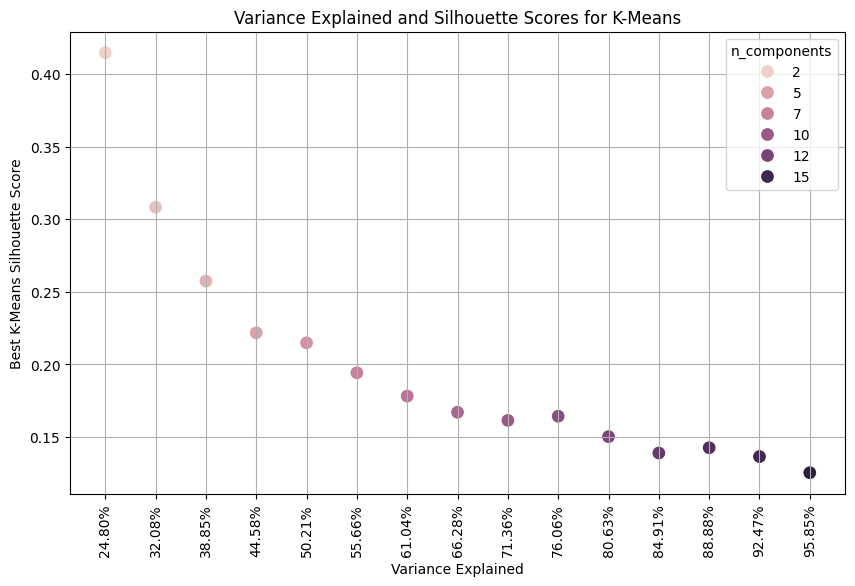

In [11]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df_hyper, x='Variance Explained', y='Best Average K-Means Silhouette Score', hue='n_components', s=100)

# Adding titles and labels
plt.title('Variance Explained and Silhouette Scores for K-Means')
plt.xlabel('Variance Explained')
plt.ylabel('Best K-Means Silhouette Score')
plt.grid(True)

# Rotate labels
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   

# Show legend with title
plt.legend(title='n_components')
plt.show()


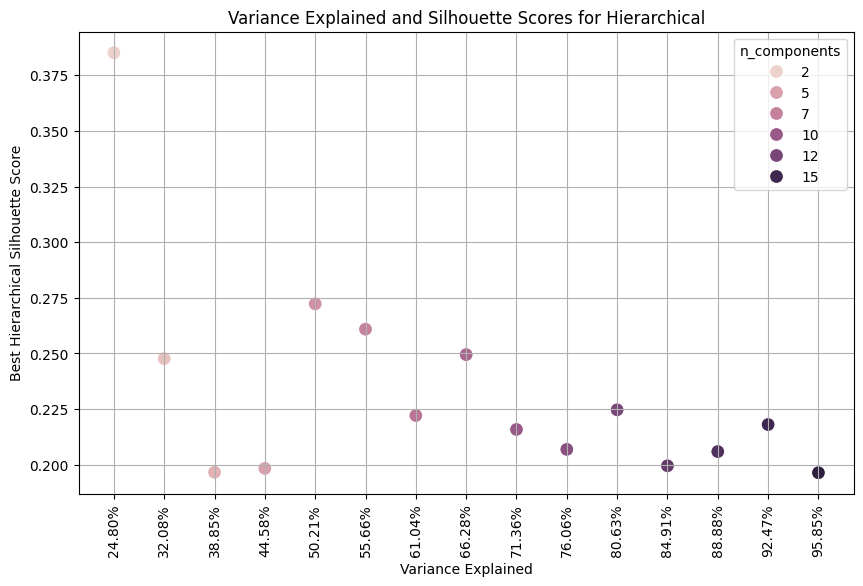

In [12]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df_hyper, x='Variance Explained', y='Best Average Hierarchical Silhouette Score', hue='n_components', s=100)

# Adding titles and labels
plt.title('Variance Explained and Silhouette Scores for Hierarchical')
plt.xlabel('Variance Explained')
plt.ylabel('Best Hierarchical Silhouette Score')
plt.grid(True)

# Rotate labels
plt.xticks(rotation=90)  
plt.yticks(rotation=0) 

# Show legend with title
plt.legend(title='n_components')
plt.show()

In [13]:

mca1 = prince.MCA(n_components=10, random_state=42)
mca1 = mca1.fit(X_train)
mca_result1 = mca1.transform(X_train)

mca1.column_contributions_.style.format('{:.0%}')
mca1.row_contributions_.style.format('{:.0%}')

variance_explained1 = mca1.eigenvalues_summary
variance_explained_reset1 = variance_explained1.reset_index()
print(variance_explained_reset1)

   component eigenvalue % of variance % of variance (cumulative)
0          0      0.184        16.39%                     16.39%
1          1      0.095         8.41%                     24.80%
2          2      0.082         7.29%                     32.08%
3          3      0.076         6.77%                     38.85%
4          4      0.065         5.73%                     44.58%
5          5      0.063         5.62%                     50.21%
6          6      0.061         5.45%                     55.66%
7          7      0.061         5.38%                     61.04%
8          8      0.059         5.24%                     66.28%
9          9      0.057         5.08%                     71.36%


In [14]:
mca_fit = prince.MCA(n_components=10, random_state=42).fit(X_train)
mca_fit.eigenvalues_summary['% of variance (cumulative)'].iloc[-1]

'71.36%'

In [15]:
mca_fit.transform(X_train)

,0,1,2,3,4,5,6,7,8,9
0,-0.690246,-0.135257,-0.241265,0.153606,0.300151,-0.251578,0.052653,-0.225271,0.160711,0.208743
1,-0.417840,-0.088388,-0.333078,0.109969,-0.192400,0.155034,0.017982,-0.175361,0.151997,-0.053578
2,-0.537536,-0.246239,0.589711,0.250013,-0.163511,-0.259297,-0.103132,0.101884,0.227769,0.318014
3,0.049529,-0.212194,0.286305,-0.090800,0.232576,-0.149389,-0.143942,-0.407750,0.218793,0.315535
4,-0.642728,-0.051964,0.317702,0.193165,0.635484,1.136239,0.133250,0.271607,0.959958,-0.026270
...,...,...,...,...,...,...,...,...,...,...
9302,0.359175,0.007618,-0.436790,0.154243,0.222241,-0.037274,-0.249384,0.500952,-0.366239,0.362950
9303,0.467990,-0.290839,0.383415,0.131483,0.028074,0.016171,0.016202,0.279983,-0.468070,-0.164785
9304,0.392202,-0.187056,-0.399595,0.110394,0.435986,-0.005904,-0.228264,-0.036267,-0.183755,-0.200982
9305,0.549869,-0.405685,0.489292,0.777990,-0.034845,0.035979,-0.079362,0.241877,-0.132308,-0.159214


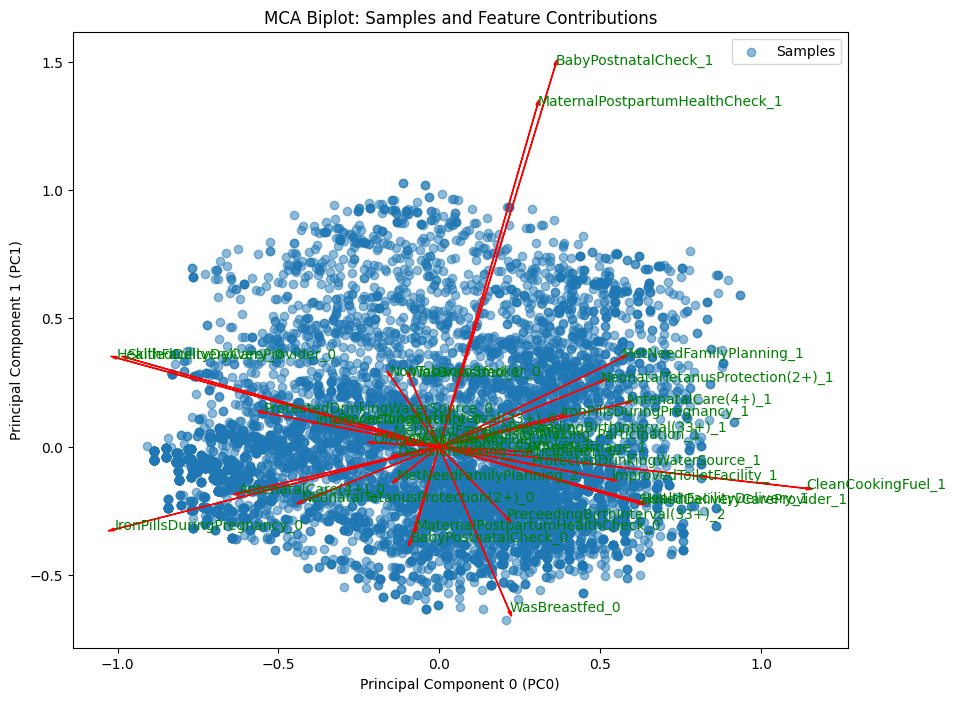

In [16]:
import matplotlib.pyplot as plt

# Get the row and column coordinates
row_coordinates1 = mca1.row_coordinates(X_train)
column_coordinates1 = mca1.column_coordinates(X_train)

# Create a new figure
plt.figure(figsize=(10, 8))

# Plot the row coordinates (the samples)
plt.scatter(row_coordinates1.iloc[:, 0], row_coordinates1.iloc[:, 1], alpha=0.5, label='Samples')

# Plot the column coordinates (the features)
for i, feature in enumerate(column_coordinates1.index):
    plt.arrow(0, 0, 
              column_coordinates1.loc[feature, 0],  
              column_coordinates1.loc[feature, 1],  
              head_width=0.01, head_length=0.02, color='red')
    plt.text(column_coordinates1.loc[feature, 0], column_coordinates1.loc[feature, 1],
             feature, color='green')

# Setting the labels and title
plt.xlabel('Principal Component 0 (PC0)')
plt.ylabel('Principal Component 1 (PC1)')
plt.title('MCA Biplot: Samples and Feature Contributions')
plt.legend()

# Show the plot
plt.show()

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Elbow curve to find optimal K
cost = {}
silhouette_scores = {}
K = range(2,12)
metrics = ["hamming", "dice", "jaccard"]
cmap = cm.get_cmap('tab10', len(inits))
for metric in metrics:
    cost[metric] = []
    silhouette_scores[metric] = []
    for num_clusters in list(K):
        kmedoids = KMedoids(n_clusters=num_clusters, metric = metric, method = 'pam', init = 'k-medoids++', random_state=42)
        cluster_labels = kmedoids.fit_predict(X_train)
        cost[metric].append(kmedoids.inertia_)
        silhouette_scores[metric].append(silhouette_score(X_train, cluster_labels))
    
for metric, color in zip(metrics, cmap.colors):
    plt.plot(K, cost[metric], color=color, marker='x', linestyle='-', label=metric)

plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.legend()
plt.show()

for metric, color in zip(metrics, cmap.colors):
    plt.plot(K, silhouette_scores[metric], color=color, marker='x', linestyle='-', label=metric)

plt.xlabel('No. of clusters')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette scores for optimal k')
plt.legend()
plt.show()


NameError: name 'inits' is not defined

In [ ]:
# Building the model with 3 clusters
kmedoids = KMedoids(n_clusters=3, metric = 'hamming', method = 'pam', init = 'k-medoids++', random_state=42)
clusters = kmedoids.fit_predict(X_train)
clusters


In [ ]:
# Add the cluster labels to the dataframe
df_train['Cluster Labels'] = kmedoids.labels_

# Calculate the sizes of each cluster (excluding noise if present)
cluster_sizes = df_train[df_train['Cluster Labels'] != -1]['Cluster Labels'].value_counts().sort_values(ascending=False)

# Create a list of cluster names in descending order of size
cluster_names = ['First', 
                 'Second', 
                 'Third', 
                 #'Fourth', 
                 #'Fifth',
                 #'Sixth',
                 #'Seventh',
                 #'Eight',
                 #'Ninth'
                ]

# Create the mapping from cluster labels to names
cluster_mapping = {label: name for label, name in zip(cluster_sizes.index, cluster_names)}

# If you have noise (label -1), add it to the mapping
if -1 in df_train['Cluster Labels'].values:
    cluster_mapping[-1] = 'Not Clustered'
    cluster_names = ['Not Clustered'] + cluster_names

# Map the cluster labels to names
df_train['Segment'] = df_train['Cluster Labels'].map(cluster_mapping)

# Convert 'Segment' to a categorical type with the new order
df_train['Segment'] = df_train['Segment'].astype('category')
df_train['Segment'] = df_train['Segment'].cat.reorder_categories(cluster_names)

# Check the result
cluster_counts = df_train['Segment'].value_counts()
cluster_counts

In [ ]:

def umap_embed(df, n_components=2, n_neighbors=100, combination="union"):
    warnings.filterwarnings('ignore', message="gradient function is not yet implemented for dice distance metric")
    warnings.filterwarnings('ignore', message="gradient function is not yet implemented for jaccard distance metric")
    warnings.filterwarnings('ignore', message="gradient function is not yet implemented for hamming distance metric")
    
    ## Nominal UMAP
    ## preprocessing nominal data
    nominal_data = df.select_dtypes(include='object')
    if not nominal_data.empty:
        #nominal_data = pd.get_dummies(nominal_data)
        nominal_data = nominal_data.astype(str)
        nominal_data_encoded = OneHotEncoder(drop='if_binary', sparse_output=False).fit_transform(nominal_data)
        
        nominal_fit = umap.UMAP(metric='hamming', 
                         n_neighbors=n_neighbors,
                         min_dist=0.0,
                         n_components=n_components, 
                         n_jobs=1,
                         random_state=42).fit(nominal_data_encoded)
        #disconnected_vertices = umap.utils.disconnected_vertices(nominal_fit)
        nominal_fit_data = pd.DataFrame(data=nominal_fit.embedding_)

    else:
        nominal_fit_data = pd.DataFrame()

    ## Numerical UMAP
    ## preprocessing numerical data
    numerical_data = df.select_dtypes(exclude='object')
    if not numerical_data.empty:
        numerical_data_standardized = StandardScaler().fit_transform(numerical_data)
        
        numerical_fit = umap.UMAP(metric='euclidean', 
                         n_neighbors=n_neighbors,
                         min_dist=0.0,
                         n_components=n_components, 
                         n_jobs=1,
                         random_state=42).fit(numerical_data_standardized)
        numerical_fit_data = pd.DataFrame(data=numerical_fit.embedding_)

    else:
        numerical_fit_data = pd.DataFrame()

    combined_embedding_data = pd.concat([numerical_fit_data, nominal_fit_data], axis=1)
        
    return combined_embedding_data, numerical_fit_data, nominal_fit_data


In [ ]:
combined_embedding_data, numerical_fit_data, nominal_fit_data = umap_embed(X_train, 
                                                                            n_components=3, 
                                                                            n_neighbors = 1000, 
                                                                            combination="union")


In [ ]:
# Now, plotting the first two components - NOMINAL ALONE
plt.figure(figsize=(7, 4))
sns.scatterplot(x=nominal_fit_data.iloc[:, 0], y=nominal_fit_data.iloc[:, 1], s=10)
plt.title('First Two Components of Nominal Data Embedding with UMAP')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(False)
plt.show()

In [ ]:
# Now, plotting the first two components - NOMINAL ALONE
plt.figure(figsize=(7, 4))
sns.scatterplot(x=nominal_fit_data.iloc[:, 0], y=nominal_fit_data.iloc[:, 1], s=10, hue=df_train['Segment'], palette='bright')
plt.title('First Two Components of Nominal Data Embedding with UMAP')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(False)
plt.show()

In [ ]:
df_new1 = df_train.copy()
df_new = df_new1[['PreceedingBirthInterval(33+)', 'WasBreastfed', 'HealthFacilityDelivery', 'SkilledDeliveryCareProvider', 
            'AntenatalCare(4+)', 'NeonatalTetanusProtection(2+)', 'IronPillsDuringPregnancy',
            'BabyPostnatalCheck', 'MaternalPostpartumHealthCheck', 'UnMetNeedFamilyPlanning',
            'CleanCookingFuel', 'ProtectedDrinkingWaterSource', 'ImprovedToiletFacility', 
            'MaternalTobaccoUse', 'DecisionMaking_Participation', 'OfAgeMarriage', 'country', 'Segment', 
            'Cluster Labels']]
df_new.info()

In [ ]:
# cluster interpretation

categorical = df_new.select_dtypes(include='object')

features_to_plot = []
features_to_drop = []

def create_contingency_table(df, feature):
    contingency_table = pd.crosstab(df[feature], df['Segment'])
    return contingency_table

for feature in df_new.columns:
    if feature not in ['Segment', 'Cluster Labels', 'country']:
        if feature in categorical.columns:
            # Categorical feature, perform Chi-square test
            contingency_table = create_contingency_table(df_new, feature)
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        else:
            # Numeric feature, perform Krusals test since we dont meet homogeneity and normalty test for ANOVA test
            segments = df_new['Segment'].unique()
            groups = [df_new[df_new['Segment'] == segment][feature] for segment in segments]
            stat, p_value = kruskal(*groups)
        
        print(f"{feature}: p-value = {p_value}")        
        if p_value < 0.05/13:
            features_to_plot.append(feature)
        else:
            features_to_drop.append(feature)
print(len(features_to_plot))
print("Features to plot:", features_to_plot)
print("Features to drop:", features_to_drop)

df_new = df_new.drop(features_to_drop, axis=1)


In [ ]:
### center and scale categorical features
categorical_columns = (df_new.select_dtypes(include=['object']).drop('country', axis=1)).columns
encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
df_dummies = pd.DataFrame(encoder.fit_transform(df_new[categorical_columns]), columns = encoder.get_feature_names_out(categorical_columns))
df_dummies_scaled = pd.DataFrame(StandardScaler().fit_transform(df_dummies), columns=df_dummies.columns)

### concatenate all the processed data
df_new = df_new.drop(categorical_columns, axis=1)
df_new = pd.concat([df_new, df_dummies_scaled], axis=1)


### get the means of features across all segments
df_new_columns = [col for col in df_new.columns if col not in ['Segment', 'country']]
aggregation_dict = {**{col: 'mean' for col in df_new_columns}}
aggregation_dict['Cluster Labels'] = 'count'
segment_summary = df_new.groupby('Segment', observed=True).agg(aggregation_dict)
segment_summary

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## data for visualization
subjects = (segment_summary.drop(columns = "Cluster Labels", axis = 1).columns).to_list()
overall = np.zeros(len(subjects)).tolist()
First = (segment_summary.loc['First', subjects]).to_list()
Second = (segment_summary.loc['Second', subjects]).to_list()
Third = (segment_summary.loc['Third', subjects]).to_list()

## Obtain angles
angles=np.linspace(0,2*np.pi,len(subjects), endpoint=False)
#print(angles)

## completing the full circle
angles=np.concatenate((angles,[angles[0]]))
subjects.append(subjects[0])
overall.append(overall[0])
First.append(First[0])
Second.append(Second[0])
Third.append(Third[0])


## Plotting
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111, polar=True)

#Overall Plot
ax.plot(angles, overall, 'o-', color='grey', linewidth=1, label='Overall: 9290')
ax.fill(angles, overall, alpha=0.25, color='grey')

#First Plot
ax.plot(angles, First, 'o-', color='orange', linewidth=1, label=f"{'First'}: {segment_summary.loc['First','Cluster Labels']}")
#ax.fill(angles, First, alpha=0.25, color='orange')

# Second Plot
ax.plot(angles, Second, 'o-', color='purple', linewidth=1, label=f"{'Second'}: {segment_summary.loc['Second','Cluster Labels']}")
#ax.fill(angles, Second, alpha=0.25, color='purple')

# Third Plot
ax.plot(angles, Third, 'o-', color='green', linewidth=1, label=f"{'Third'}: {segment_summary.loc['Third','Cluster Labels']}")
#ax.fill(angles, Third, alpha=0.25, color='green')

# Fourth Plot
#ax.plot(angles, Fourth, 'o-', color='red', linewidth=1, label=f"{'Fourth'}: {segment_summary.loc['Fourth','Cluster Labels']}")
#ax.fill(angles, Third, alpha=0.25, color='green')


ax.set_thetagrids(angles * 180/np.pi, subjects)
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
plt.show()

In [ ]:
df_new1 = df_train.copy()
df_SES = df_new1[['UrbanResidence', 'WealthIndex', 'MothersEducationalLevel', 'MothersEmploymentStatus',
                  'country', 'Segment', 'Cluster Labels']]
df_SES.info()

In [ ]:
# cluster interpretation

categorical = df_SES.select_dtypes(include='object')

features_to_plot = []
features_to_drop = []

def create_contingency_table(df, feature):
    contingency_table = pd.crosstab(df[feature], df['Segment'])
    return contingency_table

for feature in df_SES.columns:
    if feature not in ['Segment', 'Cluster Labels', 'country']:
        if feature in categorical.columns:
            # Categorical feature, perform Chi-square test
            contingency_table = create_contingency_table(df_SES, feature)
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        else:
            # Numeric feature, perform Krusals test since we dont meet homogeneity and normalty test for ANOVA test
            segments = df_SES['Segment'].unique()
            groups = [df_SES[df_SES['Segment'] == segment][feature] for segment in segments]
            stat, p_value = kruskal(*groups)
        
        print(f"{feature}: p-value = {p_value}")        
        if p_value < 0.05/4:
            features_to_plot.append(feature)
        else:
            features_to_drop.append(feature)
print(len(features_to_plot))
print("Features to plot:", features_to_plot)
print("Features to drop:", features_to_drop)

df_SES = df_SES.drop(features_to_drop, axis=1)

In [ ]:
### center and scale categorical features
categorical_columns = (df_SES.select_dtypes(include=['object']).drop('country', axis=1)).columns
encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
df_dummies = pd.DataFrame(encoder.fit_transform(df_SES[categorical_columns]), columns = encoder.get_feature_names_out(categorical_columns))
df_dummies_scaled = pd.DataFrame(StandardScaler().fit_transform(df_dummies), columns=df_dummies.columns)

### concatenate all the processed data
df_SES = df_SES.drop(categorical_columns, axis=1)
df_SES = pd.concat([df_SES, df_dummies_scaled], axis=1)


### get the means of features across all segments
df_SES_columns = [col for col in df_SES.columns if col not in ['Segment', 'country']]
aggregation_dict_SES = {**{col: 'mean' for col in df_SES_columns}}
aggregation_dict_SES['Cluster Labels'] = 'count'
segment_summary_SES = df_SES.groupby('Segment', observed=True).agg(aggregation_dict_SES)
segment_summary_SES

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## data for visualization
subjects_SES = (segment_summary_SES.drop(columns = "Cluster Labels", axis = 1).columns).to_list()
overall_SES = np.zeros(len(subjects_SES)).tolist()
First_SES = (segment_summary_SES.loc['First', subjects_SES]).to_list()
Second_SES = (segment_summary_SES.loc['Second', subjects_SES]).to_list()
Third_SES = (segment_summary_SES.loc['Third', subjects_SES]).to_list()

## Obtain angles
angles_SES=np.linspace(0,2*np.pi,len(subjects_SES), endpoint=False)
#print(angles)

## completing the full circle
angles_SES=np.concatenate((angles_SES,[angles_SES[0]]))
subjects_SES.append(subjects_SES[0])
overall_SES.append(overall_SES[0])
First_SES.append(First_SES[0])
Second_SES.append(Second_SES[0])
Third_SES.append(Third_SES[0])


## Plotting
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111, polar=True)

#Overall Plot
ax.plot(angles_SES, overall_SES, 'o-', color='grey', linewidth=1, label='Overall: 9299')
ax.fill(angles_SES, overall_SES, alpha=0.25, color='grey')

#First Plot
ax.plot(angles_SES, First_SES, 'o-', color='orange', linewidth=1, label=f"{'First'}: {segment_summary_SES.loc['First','Cluster Labels']}")
#ax.fill(angles, First, alpha=0.25, color='orange')

# Second Plot
ax.plot(angles_SES, Second_SES, 'o-', color='purple', linewidth=1, label=f"{'Second'}: {segment_summary_SES.loc['Second','Cluster Labels']}")
#ax.fill(angles, Second, alpha=0.25, color='purple')

# Third Plot
ax.plot(angles_SES, Third_SES, 'o-', color='green', linewidth=1, label=f"{'Third'}: {segment_summary_SES.loc['Third','Cluster Labels']}")
#ax.fill(angles, Third, alpha=0.25, color='green')

ax.set_thetagrids(angles_SES * 180/np.pi, subjects_SES)
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
plt.savefig('/Users/clairenajjuuko/Documents/SSA_ChildMortality/raw_datasets/Radar Plots/Three_Clusters_UMAP_KMeans_SES.png', bbox_inches='tight', dpi=300)
plt.show()

